# **Online Signature Verification Project**

### **Notebook Overview**
1. **Introduction & Data Overview**
2. **Helper Function for Feature Extraction**
3. **Data Loading & Preparation**
4. **Feature Extraction & Preprocessing**
5. **Model Training and Evaluation (Without X/Y)**
6. **Model Training and Evaluation (With X/Y)**
7. **Exploratory Analysis**
8. **Conclusion**

---
### **Project Context**
We have a dataset of signature samples, each with 5 recorded points. For each point we have:
- `X`, `Y` (pen position)
- `P` (pressure)
- `al` (altitude)
- `az` (azimuth)
- `signatureOrigin` (label: Genuine or Forged)

We want to verify whether a given signature is genuine or forged. Our plan:
1. **Load** training and testing data
2. **Extract summary features** (mean, std, min, max) per signature
3. **Train multiple ML models** (Logistic Regression, SVM, Random Forest)
4. **Evaluate** with metrics like accuracy, precision, recall, F1
5. **Compare** results **with** and **without** using `X` and `Y`

Let's get started!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Introduction & Data Overview
Before diving in, let's specify the paths where our training and test data are located, then take a quick look at the data shapes and a small sample of rows.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)

#paths
train_path = '/content/drive/My Drive/ProjectLabDataset/mcytTraining.txt'
test_path = '/content/drive/My Drive/ProjectLabDataset/mcytTesting.txt'

#load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Training Set Shape:', train_df.shape)
print('Test Set Shape:', test_df.shape)

print('\nSample of Training Data:')
display(train_df.head())

print('Sample of Testing Data:')
display(test_df.head())

Training Set Shape: (20000, 8)
Test Set Shape: (1000, 8)

Sample of Training Data:


,ID,SigID,X,Y,P,al,az,signatureOrigin
0,User0099,0099v05,29.850886,62.822232,42.751237,145.268870,86.042146,Genuine
1,User0099,0099v05,29.261045,39.342905,55.144064,127.854617,79.195756,Genuine
2,User0099,0099v05,45.561034,59.324443,56.892055,160.271755,87.879540,Genuine
3,User0099,0099v05,42.437961,46.173119,47.803956,182.199390,95.509492,Genuine
4,User0099,0099v05,39.708959,38.274359,44.461487,125.456784,148.468589,Genuine


Sample of Testing Data:


,ID,SigID,X,Y,P,al,az,signatureOrigin
0,User0099,0099v20,31.554095,50.781214,49.961595,134.141435,152.710812,Genuine
1,User0099,0099v21,37.082060,48.629675,85.632050,144.981847,95.758745,Genuine
2,User0099,0099v22,37.862421,53.921599,89.473748,114.903650,87.149426,Genuine
3,User0099,0099v23,42.501600,42.075600,73.569842,104.044011,104.512493,Genuine
4,User0099,0099v24,34.969871,46.407788,88.805109,119.137478,100.522983,Genuine


## 2. Helper Function for Feature Extraction
Since we need to group each signature by `SigID` and then compute summary statistics, we'll make a small helper function to avoid repeating code.

It does the following:
1. Groups by `SigID`
2. Computes the specified summary stats (mean, std, min, max) for the chosen features
3. Resets the index and merges back ID and signatureOrigin
4. Fills NaN std values with 0 (if a signature has the same value for all points)

We can then call this function for both our training and test sets.

In [ ]:
def extract_features(df, features_list=['P','al','az'], summary_stats=['mean','std','min','max']):
    """Groups the dataframe by SigID, computes summary stats, and merges ID + label."""

    # Group and compute summary stats
    grouped = df.groupby('SigID')[features_list].agg(summary_stats)

    # Flatten multi-level columns (e.g. P_mean, P_std, ...)
    grouped.columns = ['_'.join(col) for col in grouped.columns]

    # Reset index
    grouped = grouped.reset_index()

    # Grab meta info: ID, signatureOrigin
    meta = df.groupby('SigID').agg({
        'ID': 'first',
        'signatureOrigin': 'first'
    }).reset_index()

    # Merge back
    final_df = grouped.merge(meta, on='SigID')

    # Fill NaNs in std columns with 0
    std_cols = [col for col in final_df.columns if col.endswith('_std')]
    final_df[std_cols] = final_df[std_cols].fillna(0)

    return final_df

## 3. Data Loading & Preparation
We'll:
1. Trim whitespace from column names
2. Define label mapping (Genuine = 1, Forged = 0)
3. Split features vs. labels
4. Scale numerical features

In [ ]:
# Ensure no trailing whitespace in column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Label mapping dictionary
label_map = {'Genuine': 1, 'Forged': 0}

print("Training columns:", train_df.columns.tolist())
print("Testing columns:", test_df.columns.tolist())

Training columns: ['ID', 'SigID', 'X', 'Y', 'P', 'al', 'az', 'signatureOrigin']
Testing columns: ['ID', 'SigID', 'X', 'Y', 'P', 'al', 'az', 'signatureOrigin']


## 4. Feature Extraction & Preprocessing (Without X/Y)
In this section, we exclude `X` and `Y` to see if focusing on pen dynamics (`P`, `al`, `az`) alone is sufficient.

In [ ]:
# Features to use (exclude X/Y for now)
basic_features = ['P','al','az']
summary_stats = ['mean','std','min','max']

# Extract features for training
features_train_noXY = extract_features(train_df, basic_features, summary_stats)
# Extract features for testing
features_test_noXY = extract_features(test_df, basic_features, summary_stats)

# Encode labels
features_train_noXY['label'] = features_train_noXY['signatureOrigin'].map(label_map)
features_test_noXY['label'] = features_test_noXY['signatureOrigin'].map(label_map)

# Separate into X, y
X_train_noXY = features_train_noXY.drop(['SigID','ID','signatureOrigin','label'], axis=1)
y_train_noXY = features_train_noXY['label']
X_test_noXY = features_test_noXY.drop(['SigID','ID','signatureOrigin','label'], axis=1)
y_test_noXY = features_test_noXY['label']

# Scale data
scaler_noXY = StandardScaler()
X_train_noXY_scaled = scaler_noXY.fit_transform(X_train_noXY)
X_test_noXY_scaled = scaler_noXY.transform(X_test_noXY)

print(f"X_train_noXY shape: {X_train_noXY.shape}")
print(f"X_test_noXY shape: {X_test_noXY.shape}")

X_train_noXY shape: (4000, 12)
X_test_noXY shape: (1000, 12)


## 5. Model Training and Evaluation (Without X/Y)
We’ll train three models:
1. **Logistic Regression**
2. **SVM**
3. **Random Forest**

Then measure accuracy, precision, recall, and F1.

In [ ]:
models_noXY = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

results_noXY = []  # to store evaluation results in a list

for name, model in models_noXY.items():
    model.fit(X_train_noXY_scaled, y_train_noXY)
    y_pred = model.predict(X_test_noXY_scaled)

    acc = accuracy_score(y_test_noXY, y_pred)
    prec = precision_score(y_test_noXY, y_pred)
    rec = recall_score(y_test_noXY, y_pred)
    f1 = f1_score(y_test_noXY, y I'm_pred)

    # Store results
    results_noXY.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_noXY, y_pred))

# Create a small DataFrame of results
df_results_noXY = pd.DataFrame(results_noXY)
print("\nSummary (No X/Y):")
display(df_results_noXY)


=== Logistic Regression ===
Accuracy:  0.586
Precision: 0.747
Recall:    0.260
F1 Score:  0.386
Confusion Matrix:
[[456  44]
 [370 130]]

=== SVM ===
Accuracy:  0.659
Precision: 0.773
Recall:    0.450
F1 Score:  0.569
Confusion Matrix:
[[434  66]
 [275 225]]

=== Random Forest ===
Accuracy:  0.625
Precision: 0.773
Recall:    0.354
F1 Score:  0.486
Confusion Matrix:
[[448  52]
 [323 177]]

Summary (No X/Y):


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.586,0.747126,0.260,0.385757
1,SVM,0.659,0.773196,0.450,0.568900
2,Random Forest,0.625,0.772926,0.354,0.485597


### Confusion Matrix Heatmap
Visualizing the confusion matrix can help us quickly see how many genuine/forged signatures are misclassified.

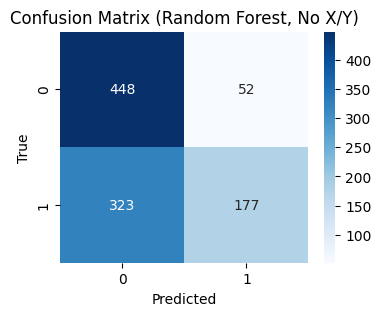

In [ ]:
#Show confusion matrix heatmap for the Random Forest model
rf_model_noXY = models_noXY['Random Forest']
y_pred_rf = rf_model_noXY.predict(X_test_noXY_scaled)
cm = confusion_matrix(y_test_noXY, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Random Forest, No X/Y)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 6. Model Training and Evaluation (With X/Y)
Now we include the `X` and `Y` features to see if spatial position helps. We repeat the same steps, but pass `["X","Y","P","al","az"]` into our helper function.

In [ ]:
# Features to include X and Y
full_features = ['X','Y','P','al','az']
summary_stats = ['mean','std','min','max']

# Extract features for training
features_train_XY = extract_features(train_df, full_features, summary_stats)
# Extract features for testing
features_test_XY = extract_features(test_df, full_features, summary_stats)

# Encode labels
features_train_XY['label'] = features_train_XY['signatureOrigin'].map(label_map)
features_test_XY['label'] = features_test_XY['signatureOrigin'].map(label_map)

# Separate into X, y
X_train_XY = features_train_XY.drop(['SigID','ID','signatureOrigin','label'], axis=1)
y_train_XY = features_train_XY['label']
X_test_XY = features_test_XY.drop(['SigID','ID','signatureOrigin','label'], axis=1)
y_test_XY = features_test_XY['label']

# Scale data
scaler_XY = StandardScaler()
X_train_XY_scaled = scaler_XY.fit_transform(X_train_XY)
X_test_XY_scaled = scaler_XY.transform(X_test_XY)

print(f"X_train_XY shape: {X_train_XY.shape}")
print(f"X_test_XY shape: {X_test_XY.shape}")

X_train_XY shape: (4000, 20)
X_test_XY shape: (1000, 20)


In [ ]:
# Train the same three models with X/Y
models_XY = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

results_XY = []

for name, model in models_XY.items():
    model.fit(X_train_XY_scaled, y_train_XY)
    y_pred = model.predict(X_test_XY_scaled)

    acc = accuracy_score(y_test_XY, y_pred)
    prec = precision_score(y_test_XY, y_pred)
    rec = recall_score(y_test_XY, y_pred)
    f1 = f1_score(y_test_XY, y_pred)

    results_XY.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

    print(f"\n=== {name} (With X/Y) ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_XY, y_pred))

# Summary DataFrame
df_results_XY = pd.DataFrame(results_XY)
print("\nSummary (With X/Y):")
display(df_results_XY)


=== Logistic Regression (With X/Y) ===
Accuracy:  0.657
Precision: 0.865
Recall:    0.372
F1 Score:  0.520
Confusion Matrix:
[[471  29]
 [314 186]]

=== SVM (With X/Y) ===
Accuracy:  0.593
Precision: 0.808
Recall:    0.244
F1 Score:  0.375
Confusion Matrix:
[[471  29]
 [378 122]]

=== Random Forest (With X/Y) ===
Accuracy:  0.705
Precision: 0.915
Recall:    0.452
F1 Score:  0.605
Confusion Matrix:
[[479  21]
 [274 226]]

Summary (With X/Y):


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.657,0.865116,0.372,0.520280
1,SVM,0.593,0.807947,0.244,0.374808
2,Random Forest,0.705,0.914980,0.452,0.605087


### Confusion Matrix Heatmap (With X/Y)
Again, a quick look at the confusion matrix for the Random Forest as an example.

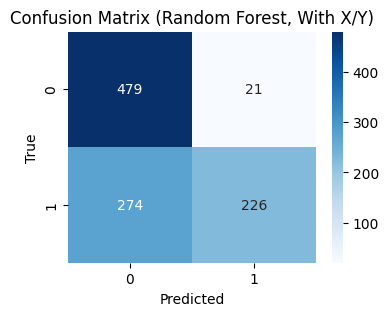

In [ ]:
rf_model_XY = models_XY['Random Forest']
y_pred_rf_XY = rf_model_XY.predict(X_test_XY_scaled)
cm_XY = confusion_matrix(y_test_XY, y_pred_rf_XY)

plt.figure(figsize=(4,3))
sns.heatmap(cm_XY, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Random Forest, With X/Y)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7. Exploratory Analysis
You can include some quick plots to see how features are distributed. For example, let’s look at the distribution of `P_mean` for genuine vs. forged in the training set *without* X/Y.

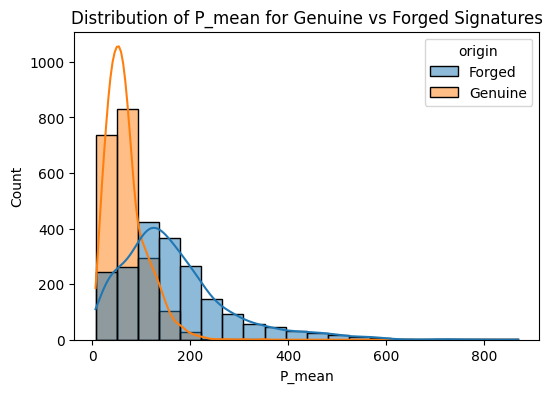

In [ ]:
#Distribution of P_mean for genuine vs forged
df_eda = features_train_noXY[['P_mean','label']].copy()
df_eda['origin'] = df_eda['label'].map({1:'Genuine', 0:'Forged'})

plt.figure(figsize=(6,4))
sns.histplot(data=df_eda, x='P_mean', hue='origin', kde=True, bins=20)
plt.title('Distribution of P_mean for Genuine vs Forged Signatures')
plt.show()

## 8. Conclusion

1. **We extracted summary features** (`mean`, `std`, `min`, `max`) for each signature’s `P`, `al`, and `az`. Later, we experimented by adding `X` and `Y` (position data) to see if they helped the models.

2. **We trained three models**: Logistic Regression, SVM, and Random Forest — and tested them with and without `X/Y`.

3. **Key observations from the results**:
   - **Without `X/Y`**:
     - **SVM** performed best overall with an F1 score of **0.569**, thanks to a decent balance between precision and recall.
     - **Random Forest** was okay but had lower recall.
     - **Logistic Regression** had the weakest performance overall.
   - **With `X/Y`**:
     - **Random Forest** improved the most, achieving the highest F1 score (**0.605**) and accuracy (**0.705**).
     - **Logistic Regression** also saw a slight improvement.
     - **SVM** actually got worse — especially in recall — which might mean it didn’t handle the added spatial features well without tuning.

4. **What could be done next**:
   - Use **hyperparameter tuning** (like GridSearchCV or RandomizedSearchCV) to improve model performance.
   - Try including **time-based or sequential features** (if available) to give the model more signing dynamics.
   - Look into **handling class imbalance** (e.g., with oversampling or class weights).
   - Add **cross-validation** to get more reliable and stable performance metrics.

---

Overall, this project shows how raw signature data can be transformed into useful features for classic ML classifiers to detect forgeries. Adding spatial info like `X/Y` helped some models (especially Random Forest), but not all — so choosing the right features still depends on the model.
